# Data Transformation by Attribute Normalization — Distribution Fitting (Box–Cox)

> Hands‑on demo to accompany the slide **‘Data Transformation by Attribute Normalization — Distribution Fitting (Box–Cox)’**. This notebook shows how to use Box–Cox to reduce skew, move data closer to a normal (bell‑shaped) distribution, and why that helps certain ML models.

**What you will learn**
- When and why to fit a distribution (normality assumption in some methods)
- Box–Cox transform: formulas, assumptions, and λ (lambda) selection
- How to compute/visualize the transform and its effect on skewness & normality
- How to invert the transform (get back to original units)
- What to do when your data contains zeros/negatives (Yeo–Johnson)
- Good practices: fit transforms on train only; handle outliers before/after

## 0. Setup (packages)
Run this cell if your environment is missing dependencies.

In [ ]:
#%pip -q install numpy pandas matplotlib seaborn scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Imports & reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.preprocessing import PowerTransformer

np.random.seed(42)
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (9, 4)

## 2. Concept — What is Box–Cox?
Box–Cox is a **power transform** that uses a parameter $\lambda$ (lambda) to make data more symmetric and closer to normal. Many statistical/ML methods benefit when residuals or inputs are approximately normal (e.g., linear models, some tests).

**Formulas (KaTeX‑safe):**
- For $\lambda \ne 0$:  $y(\lambda) = \dfrac{x^{\lambda} - 1}{\lambda}$
- For $\lambda = 0$:    $y(0) = \ln(x)$

**Assumption:** **Box–Cox requires strictly positive values** ($x > 0$).
**Goal:** choose $\lambda$ (often by maximum likelihood) that best stabilizes variance and reduces skewness.
**Note:** When zeros/negatives exist, use **Yeo–Johnson** instead (works with any real $x$).

## 3. Create a skewed positive dataset
We'll simulate **wait times** (in minutes) from an exponential‑like distribution (always positive and right‑skewed).

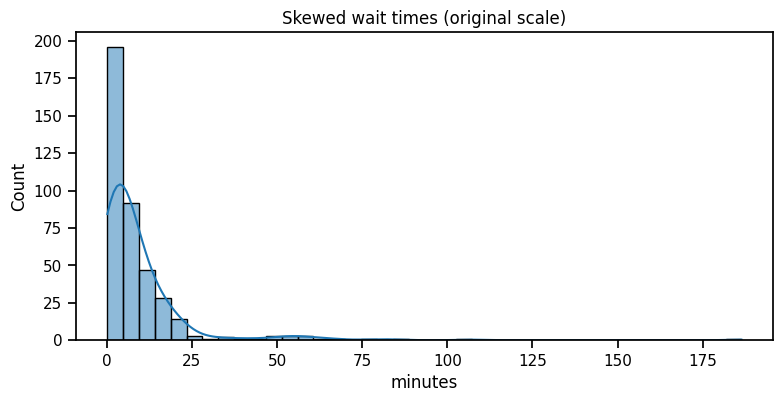

(np.float64(491.5567425518994),
 np.float64(1.8189031860781127e-107),
 np.float64(5.752984965878127),
 np.float64(49.05572069007091))

In [3]:
# Skewed data: mix of exponentials to create long tail
n = 400
wait_a = np.random.exponential(scale=6, size=int(n*0.85))
wait_b = np.random.exponential(scale=18, size=int(n*0.10))
wait_c = np.random.exponential(scale=40, size=int(n*0.05))
wait = np.concatenate([wait_a, wait_b, wait_c]) + 0.1  # ensure strictly > 0
df = pd.DataFrame({'wait_min': wait})

fig, ax = plt.subplots()
sns.histplot(df['wait_min'], bins=40, kde=True, ax=ax)
ax.set_title('Skewed wait times (original scale)')
ax.set_xlabel('minutes')
plt.show()

skew = stats.skew(df['wait_min'])
kurt = stats.kurtosis(df['wait_min'])
stats.normaltest(df['wait_min']).statistic, stats.normaltest(df['wait_min']).pvalue, skew, kurt

**Interpretation:** Large positive skew/kurtosis and a very small p‑value from a normality test indicate non‑normal data.

## 4. Find the best $\lambda$ and apply Box–Cox
We'll estimate $\lambda$ using maximum likelihood (SciPy's `boxcox_normmax`) and transform with `boxcox`.

In [4]:
x = df['wait_min'].values
lam_best = stats.boxcox_normmax(x, method='mle')
y, lam_used = stats.boxcox(x, lmbda=lam_best), lam_best
lam_used

np.float64(0.07177066118158502)

### Compare distributions (before vs after)

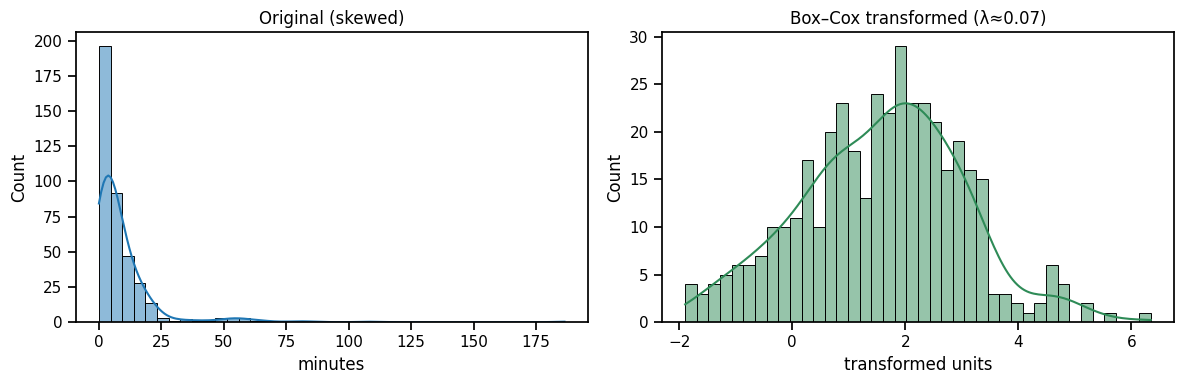

(np.float64(0.05025675747170862),
 np.float64(0.9751847110115064),
 np.float64(-0.0011337118989518155),
 np.float64(0.011541520060684096))

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(x, bins=40, kde=True, ax=axes[0])
axes[0].set_title('Original (skewed)')
axes[0].set_xlabel('minutes')
sns.histplot(y, bins=40, kde=True, ax=axes[1], color='seagreen')
axes[1].set_title(f'Box–Cox transformed (λ≈{lam_used:.2f})')
axes[1].set_xlabel('transformed units')
plt.tight_layout(); plt.show()

# Normality metrics after transformation
skew2 = stats.skew(y)
kurt2 = stats.kurtosis(y)
stats.normaltest(y).statistic, stats.normaltest(y).pvalue, skew2, kurt2

### Q–Q plots (visual normality check)

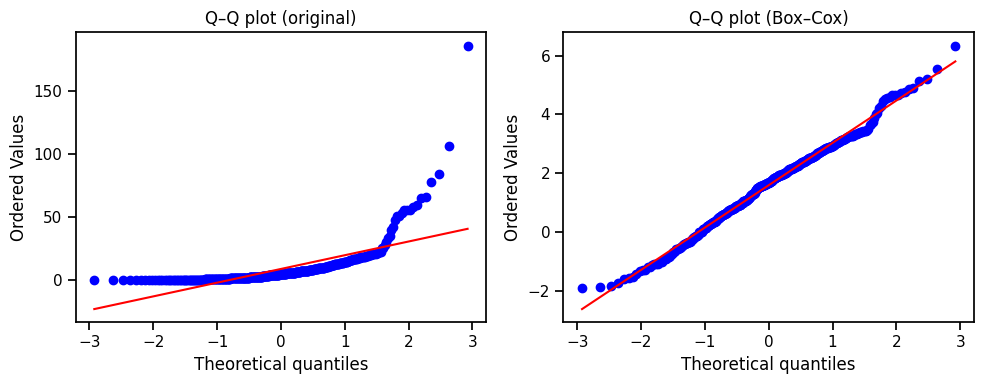

In [6]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
stats.probplot(x, dist='norm', plot=axes[0])
axes[0].set_title('Q–Q plot (original)')
stats.probplot(y, dist='norm', plot=axes[1])
axes[1].set_title('Q–Q plot (Box–Cox)')
plt.tight_layout(); plt.show()

## 5. Choosing $\lambda$: grid view using log‑likelihood
Box–Cox typically chooses $\lambda$ that **maximizes the log‑likelihood** of seeing the data if it were normal after transformation. Let's visualize this criterion.

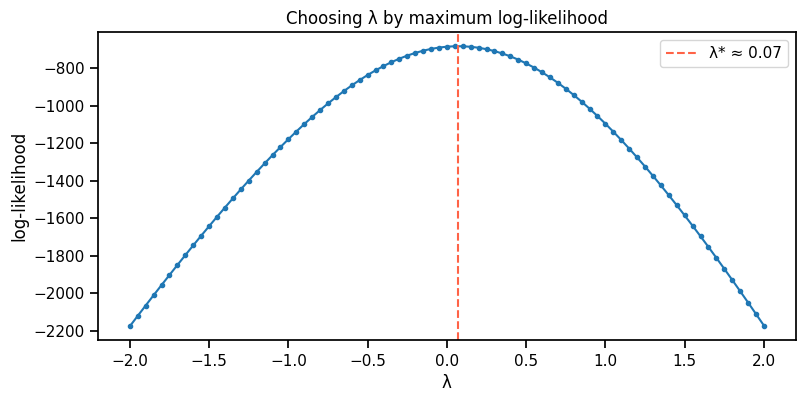

In [7]:
lambdas = np.linspace(-2, 2, 81)
llf = [stats.boxcox_llf(l, x) for l in lambdas]  # <- positional args

fig, ax = plt.subplots()
ax.plot(lambdas, llf, '-o', ms=3)
ax.axvline(lam_used, color='tomato', linestyle='--', label=f'λ* ≈ {lam_used:.2f}')
ax.set_xlabel('λ')
ax.set_ylabel('log-likelihood')
ax.set_title('Choosing λ by maximum log-likelihood')
ax.legend(); plt.show()


## 6. Inverse transform (back to original units)
You can always **recover original values** using `inv_boxcox`.

In [8]:
# Take a few transformed values and invert them
sample_y = np.array([y.min(), np.median(y), y.max()])
recovered_x = inv_boxcox(sample_y, lam_used)
pd.DataFrame({'transformed_y': sample_y.round(4), 'recovered_minutes': recovered_x.round(4)})

,transformed_y,recovered_minutes
0,-1.8949,0.1304
1,1.6783,4.8775
2,6.3436,186.3802


## 7. What if there are zeros or negatives? (Yeo–Johnson)
Box–Cox needs **x > 0**. For data with zeros/negatives, use **Yeo–Johnson** via scikit‑learn's `PowerTransformer(method='yeo-johnson')`.

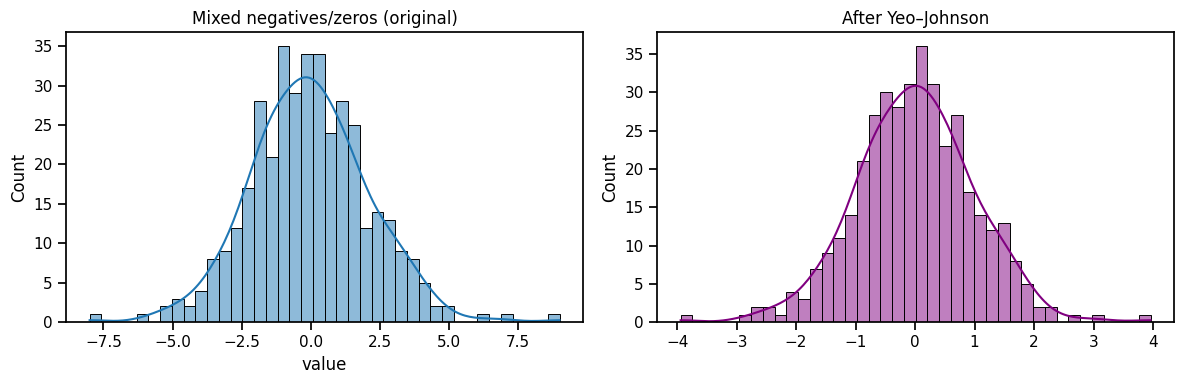

In [9]:
mixed = np.concatenate([np.random.normal(loc=0, scale=2, size=380), np.array([-8, -6, -5, 7, 9])])
df_mixed = pd.DataFrame({'value': mixed})
pt_yj = PowerTransformer(method='yeo-johnson')
yj = pt_yj.fit_transform(df_mixed[['value']]).ravel()
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_mixed['value'], bins=40, kde=True, ax=axes[0])
axes[0].set_title('Mixed negatives/zeros (original)')
sns.histplot(yj, bins=40, kde=True, ax=axes[1], color='purple')
axes[1].set_title('After Yeo–Johnson')
plt.tight_layout(); plt.show()

## 8. Using Box–Cox/Yeo–Johnson in a pipeline
In practice, apply transforms **only on the training split** and reuse the fitted transformer for validation/test to avoid leakage.

In [10]:
from sklearn.model_selection import train_test_split
X = df[['wait_min']].copy()
X_train, X_test = train_test_split(X, test_size=0.25, random_state=42)
pt_bc = PowerTransformer(method='box-cox', standardize=False)  # requires X>0
X_train_bc = pt_bc.fit_transform(X_train)
X_test_bc = pt_bc.transform(X_test)  # reuse fitted lambda
pt_bc.lambdas_  # learned λ for the column(s)

array([0.09753283])

## 9. Quick checklist & caveats
- Ensure all values are **> 0** before Box–Cox (shift if needed).
- Remove/handle extreme outliers; they can distort λ and plots.
- Fit transformation on **training data only**; apply to validation/test with `.transform()`.
- Inspect with histograms and Q–Q plots, and confirm with a normality test.
- Keep track of λ to enable **inverse transforms** for interpretability.

## 10. Practice exercises
1. Add a constant shift so that the smallest value is 0.0001, then apply Box–Cox. Compare λ and normality.
2. Try a different skewed feature (e.g., `np.random.lognormal`) and repeat the steps.
3. Make a λ grid from −1.5 to +1.5 and find the λ that minimizes |skewness|. Does it match the MLE λ?
4. Use `PowerTransformer(method='box-cox', standardize=True)` and check how standardization alters the result.
5. Fit a simple linear regression on original vs Box–Cox‑transformed `wait_min` to predict a synthetic target; compare residual plots.

---
_Last updated: 2026-02-15 18:01:04 UTC_